In [1]:
%autosave 60

Autosaving every 60 seconds


In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
import seaborn as sns

## Загрузка данных

In [3]:
df = pd.read_csv('../Downloads/kkbox-music-recommendation-challenge/train.csv/train.csv')

In [4]:
songs = pd.read_csv('../Downloads/kkbox-music-recommendation-challenge/songs.csv/songs.csv')
df = pd.merge(df, songs, on='song_id', how='left')
del songs

# Load and join members data
members = pd.read_csv('../Downloads/kkbox-music-recommendation-challenge/members.csv/members.csv')
df = pd.merge(df, members, on='msno', how='left')
del members

## EDA

In [5]:
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,registration_init_time,expiration_date
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,1,0,NaN,7,20120102,20171005
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,NaN,NaN,52.0,13,24,female,9,20110525,20170911
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,13,24,female,9,20110525,20170911
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0,13,24,female,9,20110525,20170911
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0,1,0,NaN,7,20120102,20171005


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 18 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   msno                    object 
 1   song_id                 object 
 2   source_system_tab       object 
 3   source_screen_name      object 
 4   source_type             object 
 5   target                  int64  
 6   song_length             float64
 7   genre_ids               object 
 8   artist_name             object 
 9   composer                object 
 10  lyricist                object 
 11  language                float64
 12  city                    int64  
 13  bd                      int64  
 14  gender                  object 
 15  registered_via          int64  
 16  registration_init_time  int64  
 17  expiration_date         int64  
dtypes: float64(2), int64(6), object(10)
memory usage: 1.0+ GB


In [7]:
df.describe()

,target,song_length,language,city,bd,registered_via,registration_init_time,expiration_date
count,7.377418e+06,7.377304e+06,7.377268e+06,7.377418e+06,7.377418e+06,7.377418e+06,7.377418e+06,7.377418e+06
mean,5.035171e-01,2.451210e+05,1.860933e+01,7.511399e+00,1.753927e+01,6.794068e+00,2.012810e+07,2.017157e+07
std,4.999877e-01,6.734471e+04,2.117681e+01,6.641625e+00,2.155447e+01,2.275774e+00,3.017281e+04,3.869831e+03
min,0.000000e+00,1.393000e+03,-1.000000e+00,1.000000e+00,-4.300000e+01,3.000000e+00,2.004033e+07,1.970010e+07
25%,0.000000e+00,2.147260e+05,3.000000e+00,1.000000e+00,0.000000e+00,4.000000e+00,2.011070e+07,2.017091e+07
50%,1.000000e+00,2.418120e+05,3.000000e+00,5.000000e+00,2.100000e+01,7.000000e+00,2.013102e+07,2.017093e+07
75%,1.000000e+00,2.721600e+05,5.200000e+01,1.300000e+01,2.900000e+01,9.000000e+00,2.015102e+07,2.017101e+07
max,1.000000e+00,1.085171e+07,5.900000e+01,2.200000e+01,1.051000e+03,1.300000e+01,2.017013e+07,2.020102e+07


### Оценим количество уникальных значений в столбцах

In [8]:
for col in df.columns:
    print(col,'unique values:', df[col].nunique())

msno unique values: 30755
song_id unique values: 359966
source_system_tab unique values: 8
source_screen_name unique values: 20
source_type unique values: 12
target unique values: 2
song_length unique values: 60266
genre_ids unique values: 572
artist_name unique values: 40582
composer unique values: 76064
lyricist unique values: 33888
language unique values: 10
city unique values: 21
bd unique values: 92
gender unique values: 2
registered_via unique values: 5
registration_init_time unique values: 3811
expiration_date unique values: 1395


### Оценим количество пропусков в данных

In [9]:
dtypes = pd.DataFrame(df.dtypes,columns=["Data Type"])

dtypes["Unique Values"]=df.nunique().sort_values(ascending=True)
dtypes["Null Values"]=df.isnull().sum()
dtypes["% null Values"]=df.isnull().sum()/len(df)

dtypes.sort_values(by="Null Values" , ascending=False).style.background_gradient(cmap='YlGnBu',axis=0)

,Data Type,Unique Values,Null Values,% null Values
lyricist,object,33888,3178798,0.430882
gender,object,2,2961479,0.401425
composer,object,76064,1675706,0.227140
source_screen_name,object,20,414804,0.056226
genre_ids,object,572,118455,0.016056
source_system_tab,object,8,24849,0.003368
source_type,object,12,21539,0.002920
language,float64,10,150,0.000020
song_length,float64,60266,114,0.000015
artist_name,object,40582,114,0.000015


### Заполним пропуски

In [10]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna(value = 'missed')
    
for col in df.select_dtypes(exclude=['object']).columns:
    df[col] = df[col].fillna(value = df[col].median())

In [11]:
df.isna().sum()

msno                      0
song_id                   0
source_system_tab         0
source_screen_name        0
source_type               0
target                    0
song_length               0
genre_ids                 0
artist_name               0
composer                  0
lyricist                  0
language                  0
city                      0
bd                        0
gender                    0
registered_via            0
registration_init_time    0
expiration_date           0
dtype: int64

### Приведем ***registration_init_time*** и  ***expiration_date*** к типу datetime.

### Вынесем день/месяц/год в отдельные фичи.

In [12]:
df['registration_init_time'] = pd.to_datetime(df['registration_init_time'], format='%Y%m%d', errors='ignore')
df['registration_init_time_year'] = df['registration_init_time'].dt.year
df['registration_init_time_month'] = df['registration_init_time'].dt.month
df['registration_init_time_day'] = df['registration_init_time'].dt.day

df['expiration_date'] = pd.to_datetime(df['expiration_date'],  format='%Y%m%d', errors='ignore')
df['expiration_date_year'] = df['expiration_date'].dt.year
df['expiration_date_month'] = df['expiration_date'].dt.month
df['expiration_date_day'] = df['expiration_date'].dt.day

df['registration_init_time'] = df['registration_init_time'].astype('category')
df['expiration_date'] = df['expiration_date'].astype('category')

In [13]:
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,...,missed,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,missed,...,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,...,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,...,female,9,2011-05-25,2017-09-11,2011,5,25,2017,9,11
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,...,missed,7,2012-01-02,2017-10-05,2012,1,2,2017,10,5


In [14]:
df.dtypes

msno                              object
song_id                           object
source_system_tab                 object
source_screen_name                object
source_type                       object
target                             int64
song_length                      float64
genre_ids                         object
artist_name                       object
composer                          object
lyricist                          object
language                         float64
city                               int64
bd                                 int64
gender                            object
registered_via                     int64
registration_init_time          category
expiration_date                 category
registration_init_time_year        int64
registration_init_time_month       int64
registration_init_time_day         int64
expiration_date_year               int64
expiration_date_month              int64
expiration_date_day                int64
dtype: object

In [15]:
numer = df.select_dtypes(include=['int64', 'float64']).columns
categ = df.select_dtypes(include=['object', 'category']).columns

In [16]:
numer

Index(['target', 'song_length', 'language', 'city', 'bd', 'registered_via',
       'registration_init_time_year', 'registration_init_time_month',
       'registration_init_time_day', 'expiration_date_year',
       'expiration_date_month', 'expiration_date_day'],
      dtype='object')

### Закодируем категориальные признаки

In [17]:
le = LabelEncoder()

for col in categ:
    df[col] = le.fit_transform(df[col])

In [18]:
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,8158,74679,1,7,7,1,206471.0,285,3277,14581,...,2,7,2131,989,2012,1,2,2017,10,5
1,17259,223479,4,8,4,1,284584.0,90,31960,64864,...,0,9,1909,965,2011,5,25,2017,9,11
2,17259,120758,4,8,4,1,225396.0,90,21372,45057,...,0,9,1909,965,2011,5,25,2017,9,11
3,17259,23707,4,8,4,1,255512.0,6,27439,36700,...,0,9,1909,965,2011,5,25,2017,9,11
4,8158,33308,1,7,7,1,187802.0,2,4472,8485,...,2,7,2131,989,2012,1,2,2017,10,5


### Поистроим матрицу корреляций для оценки зависимотей в данных

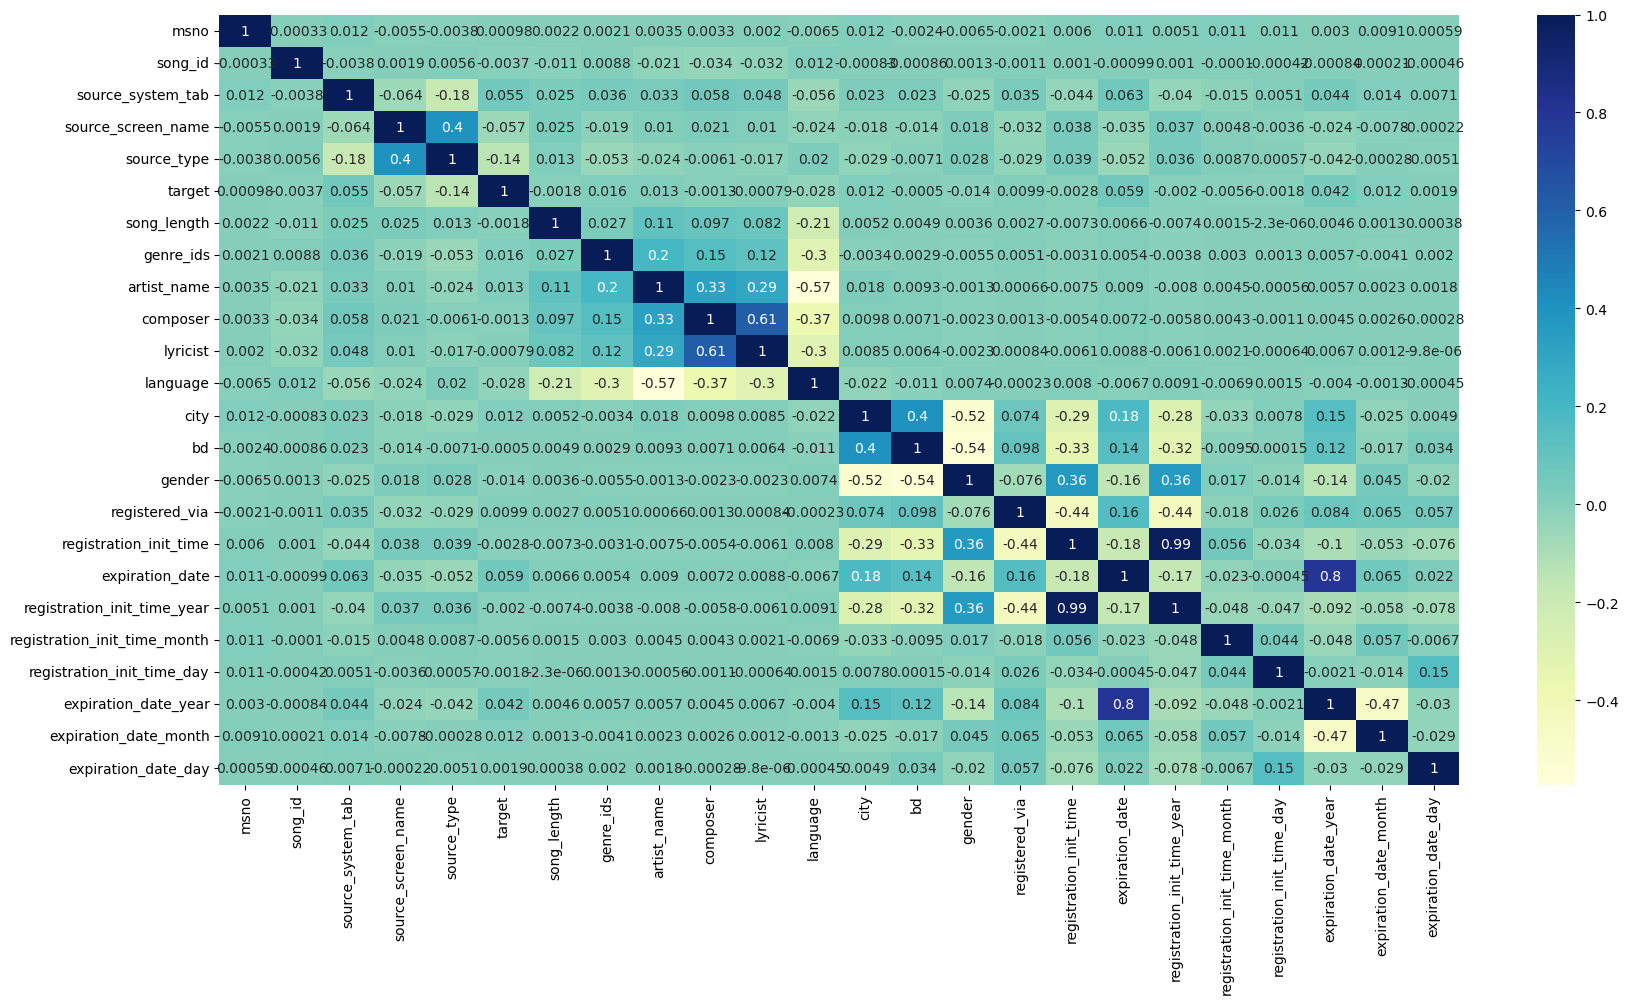

In [19]:
plt.figure(figsize=[20,10])
sns.heatmap(df.corr(), annot=True, cmap='YlGnBu')
plt.show()

- **target не имеет сильных корреляций с признаками.**

- **language имеет слабую корреляцию с song_lenght, genre_ids, artist_name, composer, lyrics.**

- **Больших корреляций между признаками нет, кроме expiration_date и expiration_date_year**

### Оценим распределения числовых фичей

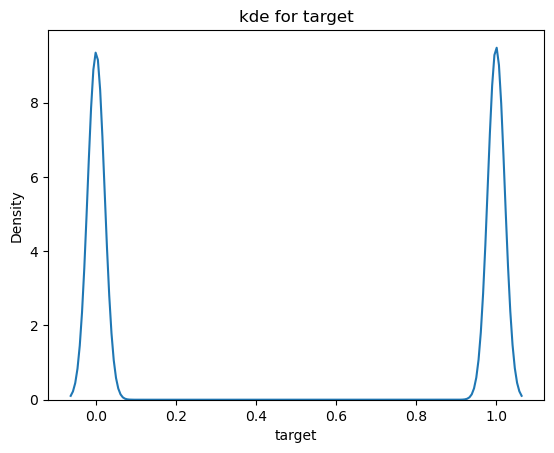

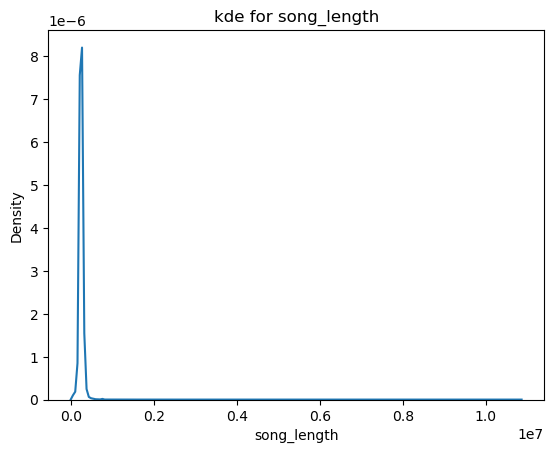

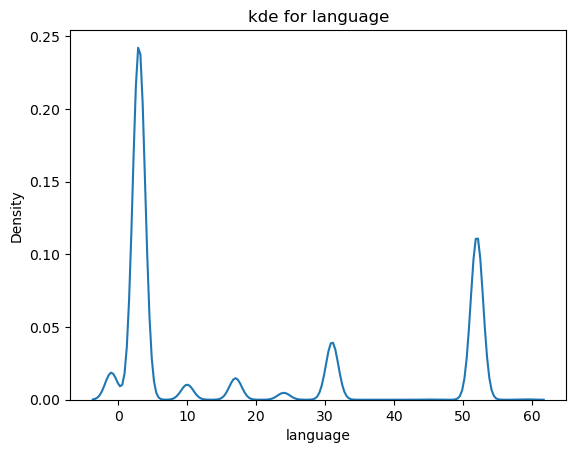

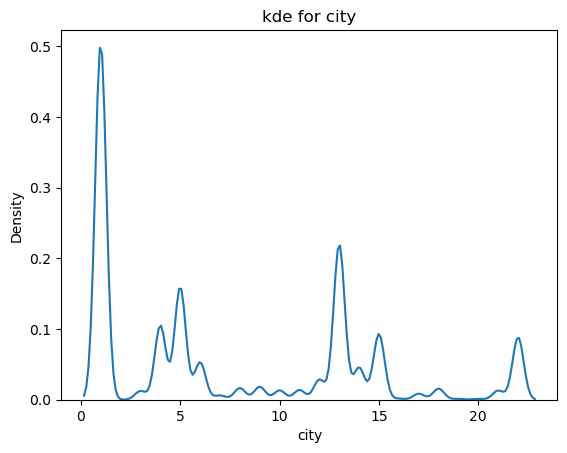

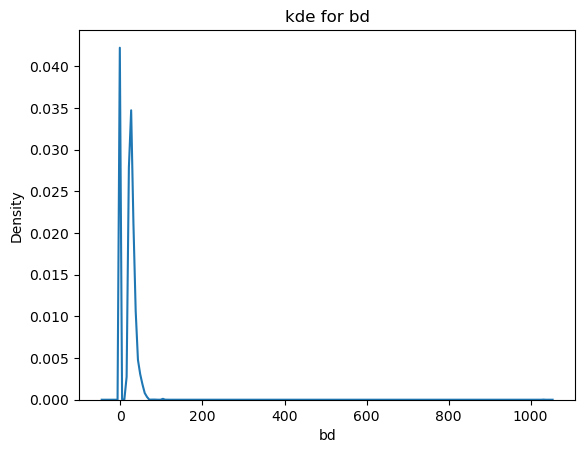

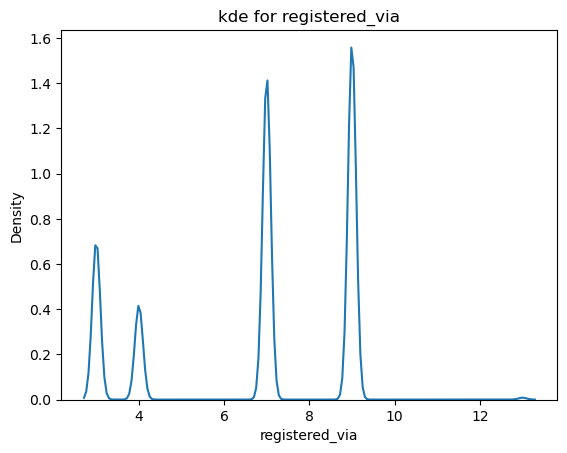

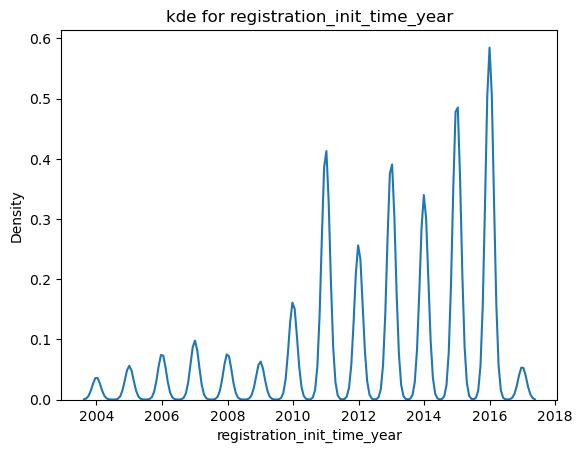

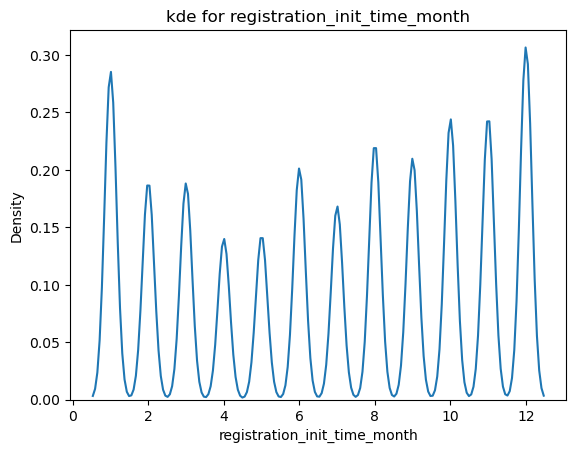

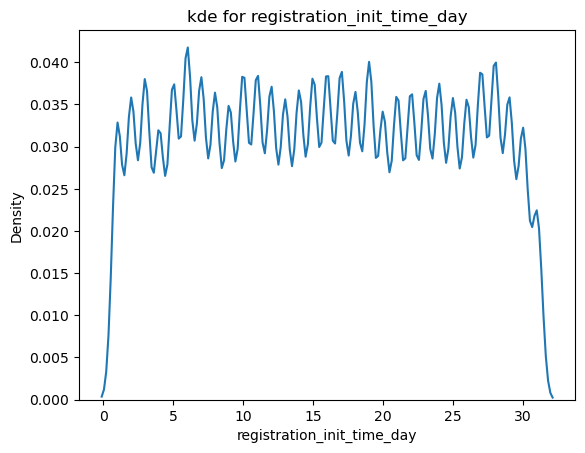

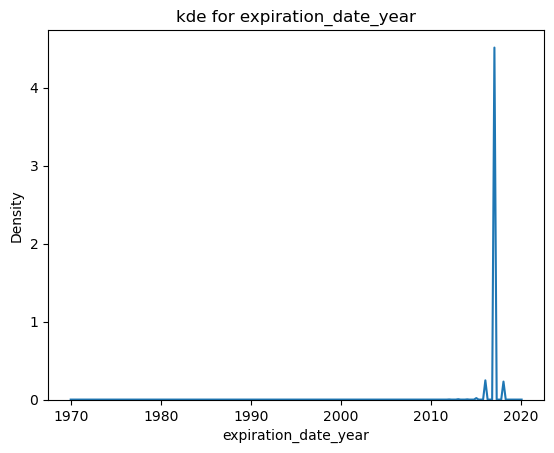

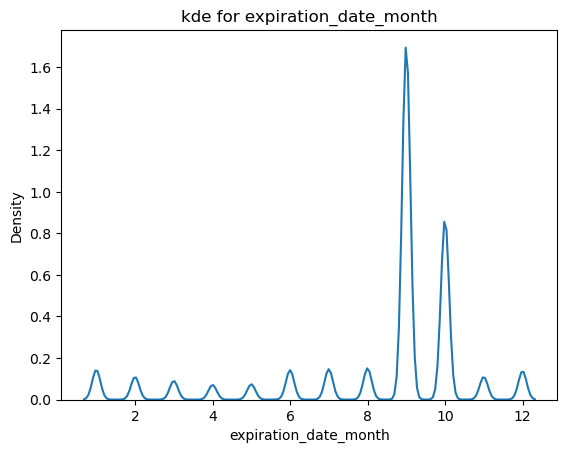

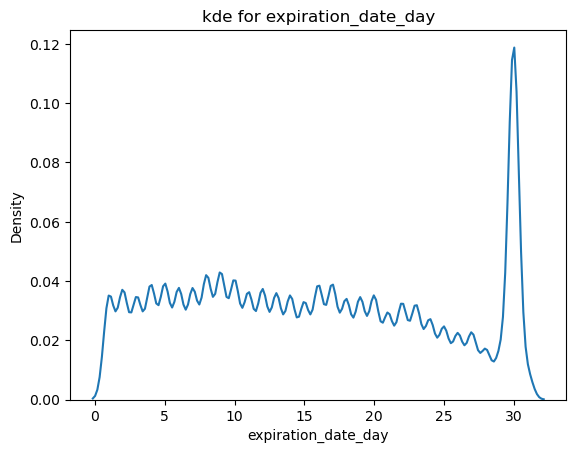

In [20]:
for col in numer:
    plt.title(f'kde for {col}')
    sns.kdeplot(df[col])
    plt.show()

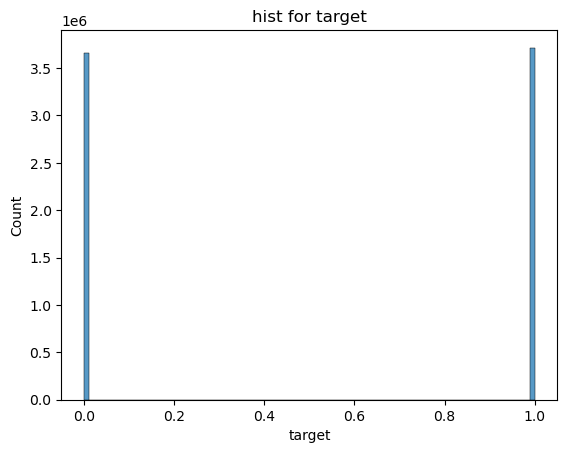

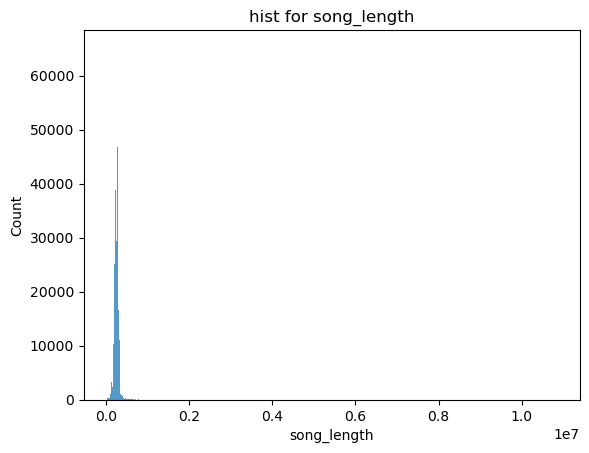

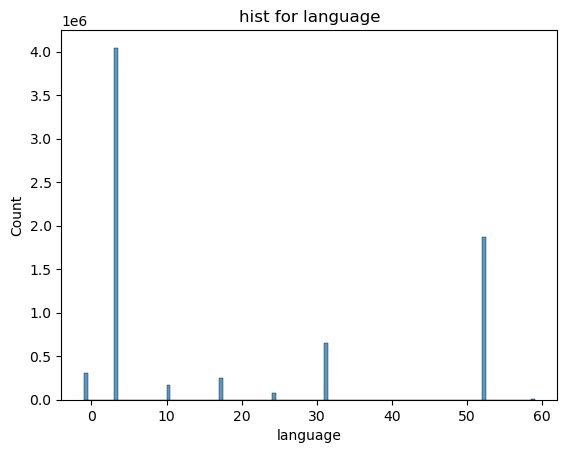

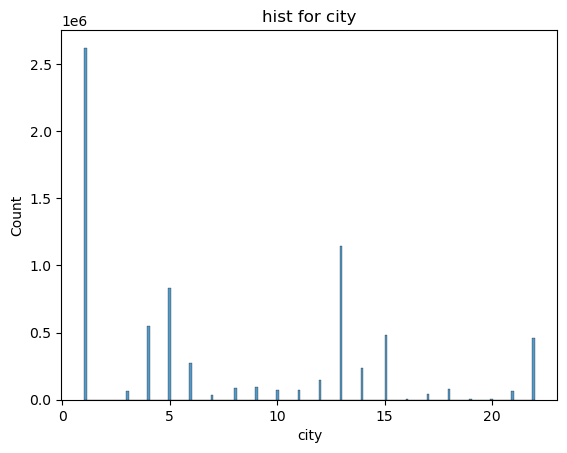

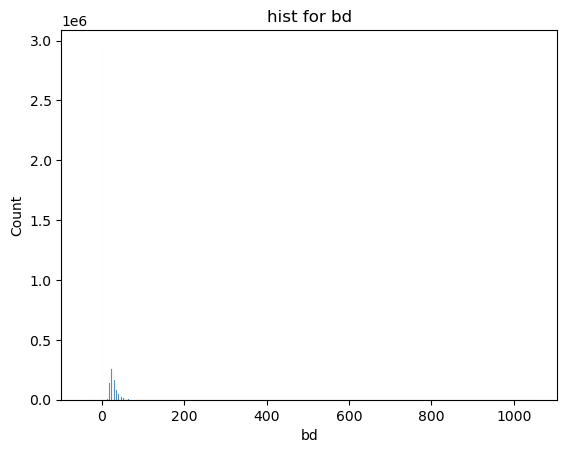

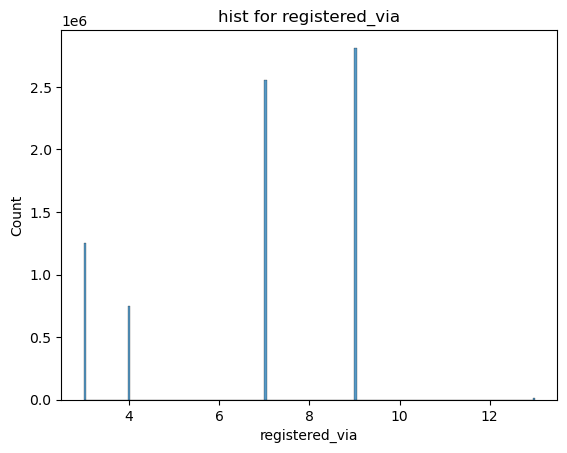

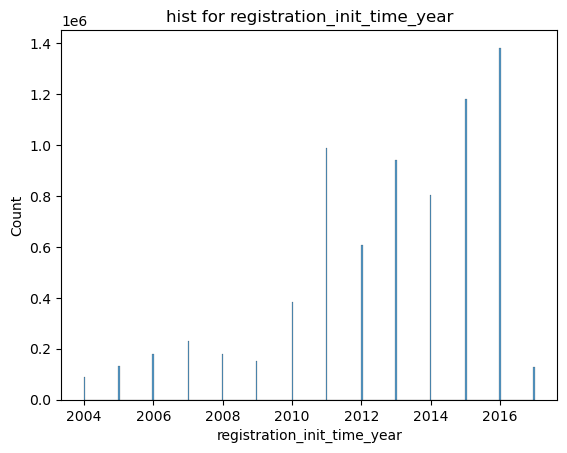

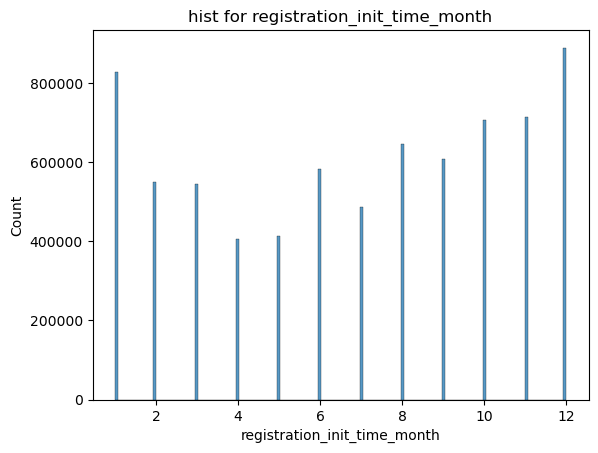

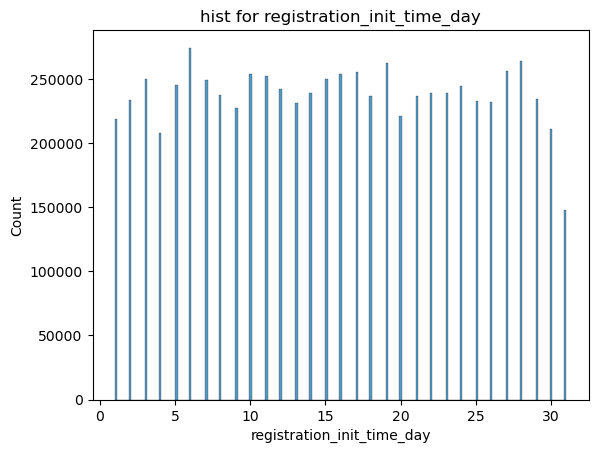

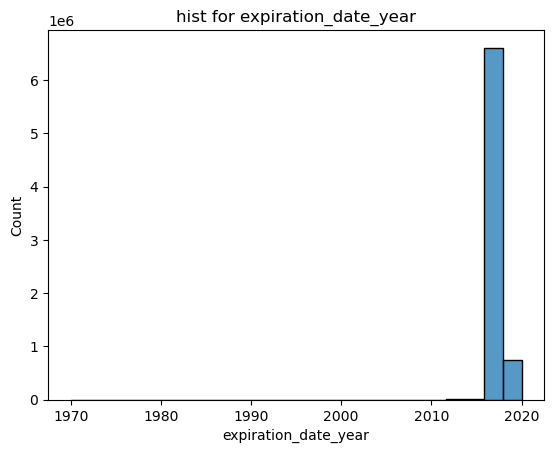

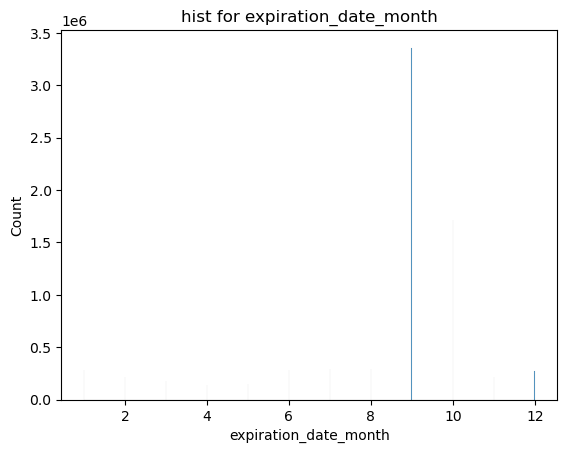

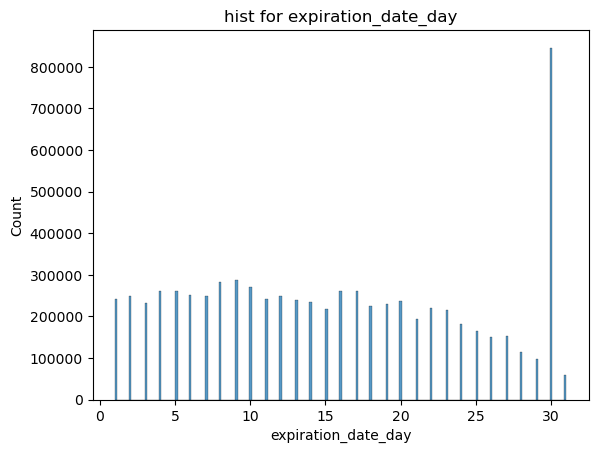

In [21]:
for col in numer:
    plt.title(f'hist for {col}')
    sns.histplot(df[col])
    plt.show()

### Разобъем датасет на тренировочную и валидационную выборку

In [22]:
y = df['target']
X = df.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y)

### Используемая метрика NDSG

### ***NDCG*** - это показатель, который оценивает качество рекомендаций и систем поиска информации. 

### ***NDCG*** помогает оценить способность алгоритмов машинного обучения сортировать на основе релевантности.

### LGBM

In [28]:
LGBM = LGBMClassifier(learning_rate=0.2, verbose=0, num_leaves=100, bagging_fraction=0.95)
LGBM.fit(X_train, y_train)

y_pred_lgbm =LGBM.predict(X_test)
ndcg_score([y_test], [y_pred_lgbm], k=20)

[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.161916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


0.6649380526175142

### CatBoost

In [29]:
cat = CatBoostClassifier(learning_rate=0.1, depth=10, iterations=200, verbose=False)
cat.fit(X_train, y_train, plot=True)

y_pred_cat =cat.predict(X_test)
print(ndcg_score([y_test], [y_pred_cat], k=20))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0.6535467167047063


## XGBoost

In [27]:
XGB = XGBClassifier(learning_rate=0.1, max_depth=15, min_child_weight=5)
XGB.fit(X_train, y_train)

y_pred_xgb =XGB.predict(X_test)
ndcg_score([y_test], [y_pred_xgb], k=20)

0.7201325219070697

## В качестве итоговой модели, можно выбрать XGBoost, т.к. она показывает лучшее значение метрики.